In [1]:
import sys
import os
os.chdir('..')
sys.path.append('py//models')
from model_funs import *
X, y = get_x_y('data_for_modelling')
X_hold, y_hold = get_x_y('holdout')

In [2]:
def reverse_one_hot(X, col_patterns):
    X_new = X.copy()
    for single_pattern in col_patterns:
        cols = get_cols_with_pattern(X, f'{single_pattern}')
        df = X[cols]
        df[f'{single_pattern}'] = df.idxmax(axis=1).str.replace(f'{single_pattern}_', '')
    
        X_new = X_new.drop(columns = cols)
        X_new[f'{single_pattern}'] = df[f'{single_pattern}']
    
    return X_new

In [11]:
current_model = XGBRegressor(eval_metric = 'mae', 
                             tree_method='hist', 
                             device='cuda'
                 )
    
current_X = X.copy()
print("XGB check")
param_grid = {'n_estimators': np.arange(180, 183, 1), 
              'max_depth': np.arange(5, 7, 1),     
              'learning_rate': np.arange(0.10, 0.12, 0.01)
            }


grid_search = GridSearchCV(current_model, 
                           param_grid, 
                           cv = 5, 
                           scoring = 'neg_mean_absolute_error', 
                           return_train_score = False,
                           verbose = 1
             )

grid_search.fit(current_X, y)

XGB_best = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best MAE: {:.2f}".format(-grid_search.best_score_))
print("")
print("")

XGB check
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'learning_rate': 0.11, 'max_depth': 6, 'n_estimators': 182}
Best MAE: 20407.33




In [12]:
errors = XGB_best.predict(X_hold) - y_hold
print(np.abs(errors).describe())
get_MAE(errors)
get_MAPE(errors, y_hold)

count     1000.0000
mean     20038.9821
std      23683.4445
min          8.8125
25%       4978.4922
50%      12361.7148
75%      25627.3203
max     197170.3125
Name: price, dtype: float64
MAE 20038.98206640625
MAPE 17.92513727367004%


0.1792513727367004

In [13]:
print(f"errors 95%: {np.quantile(errors, 0.95)}")
print(f"errors 5%: {np.quantile(errors, 0.05)}")

errors 95%: 44468.71796874998
errors 5%: -54121.1578125


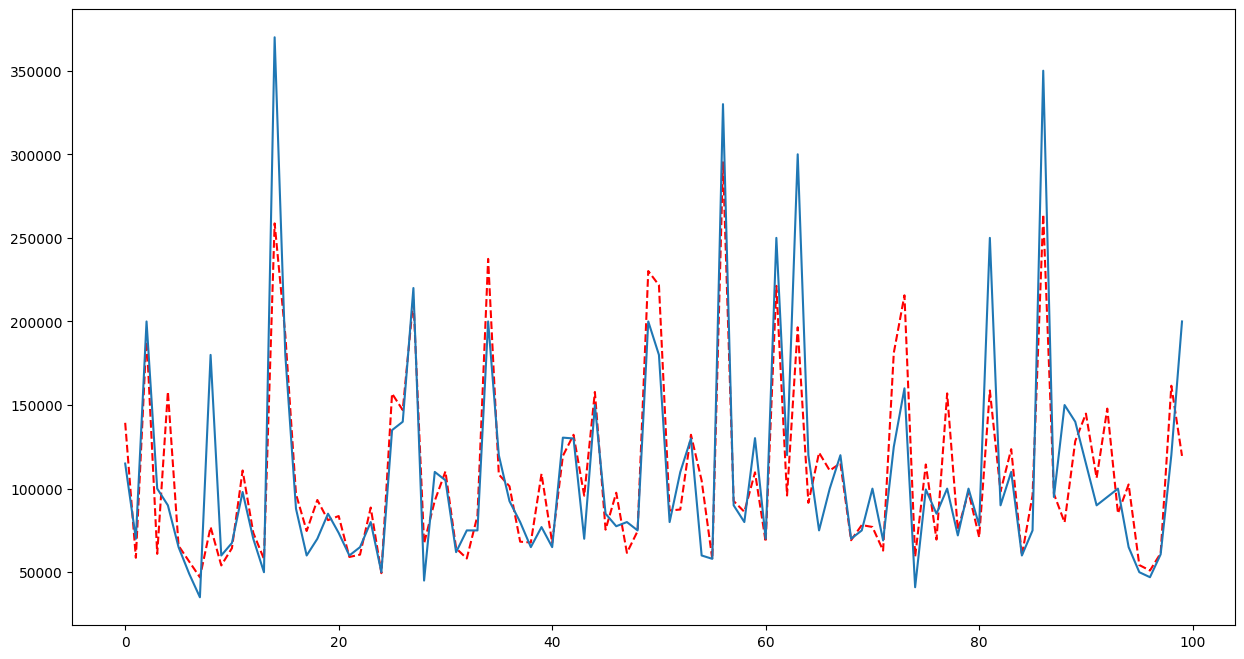

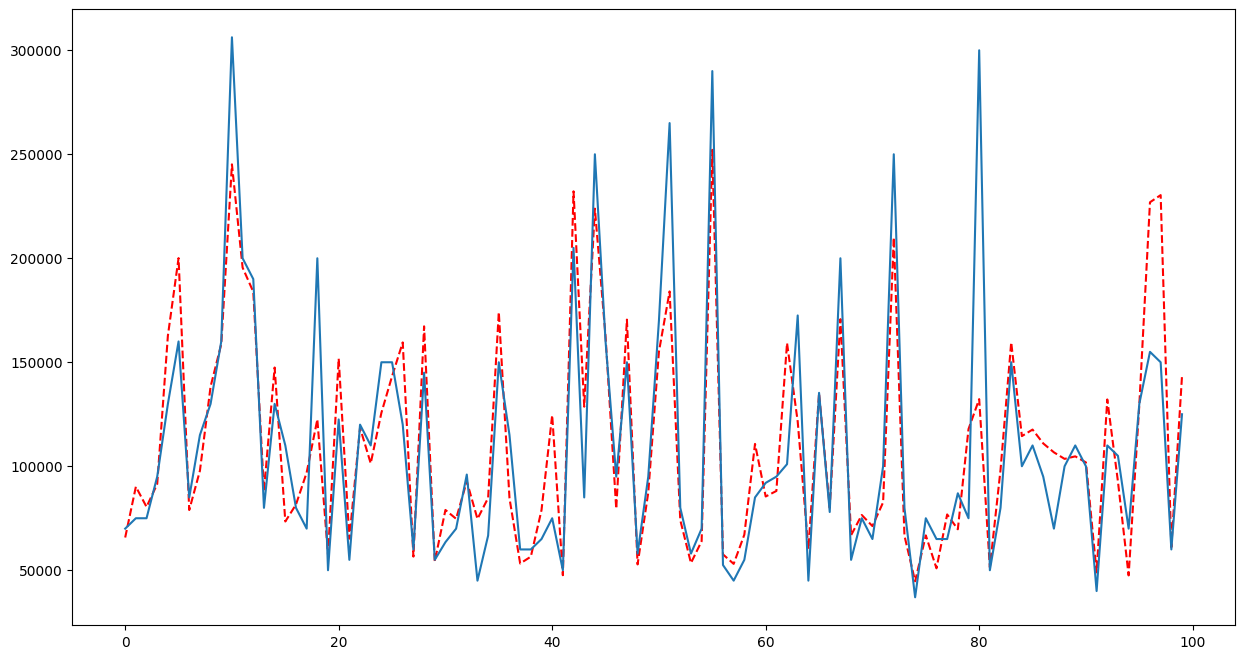

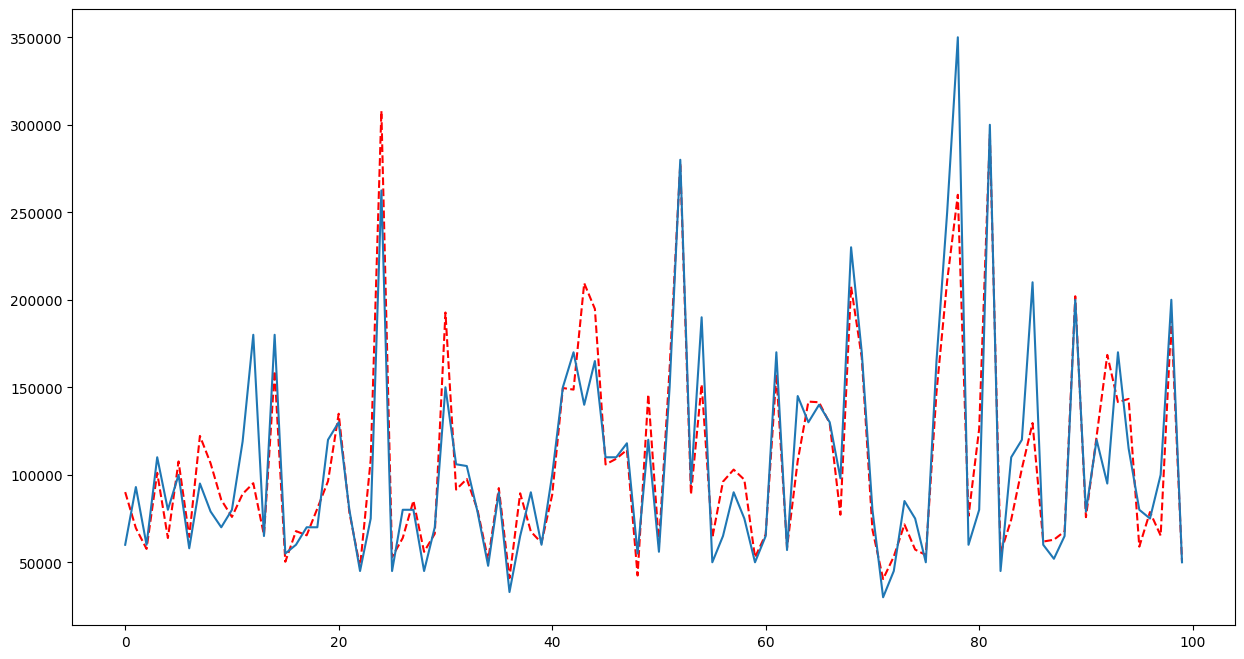

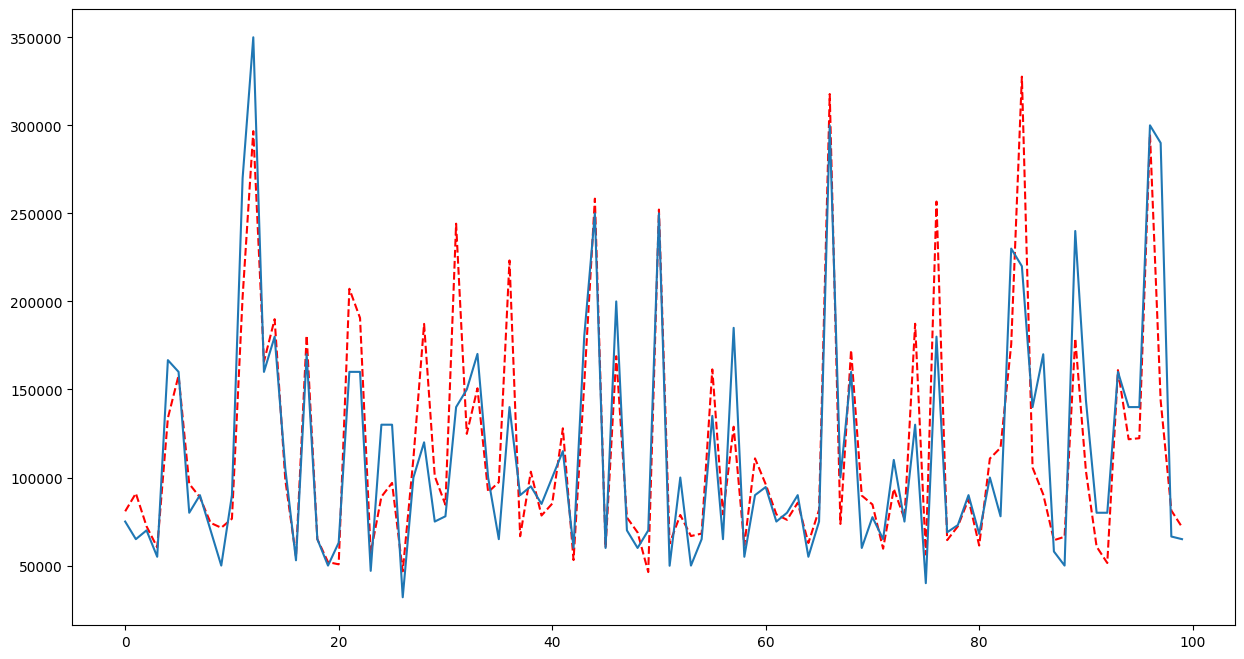

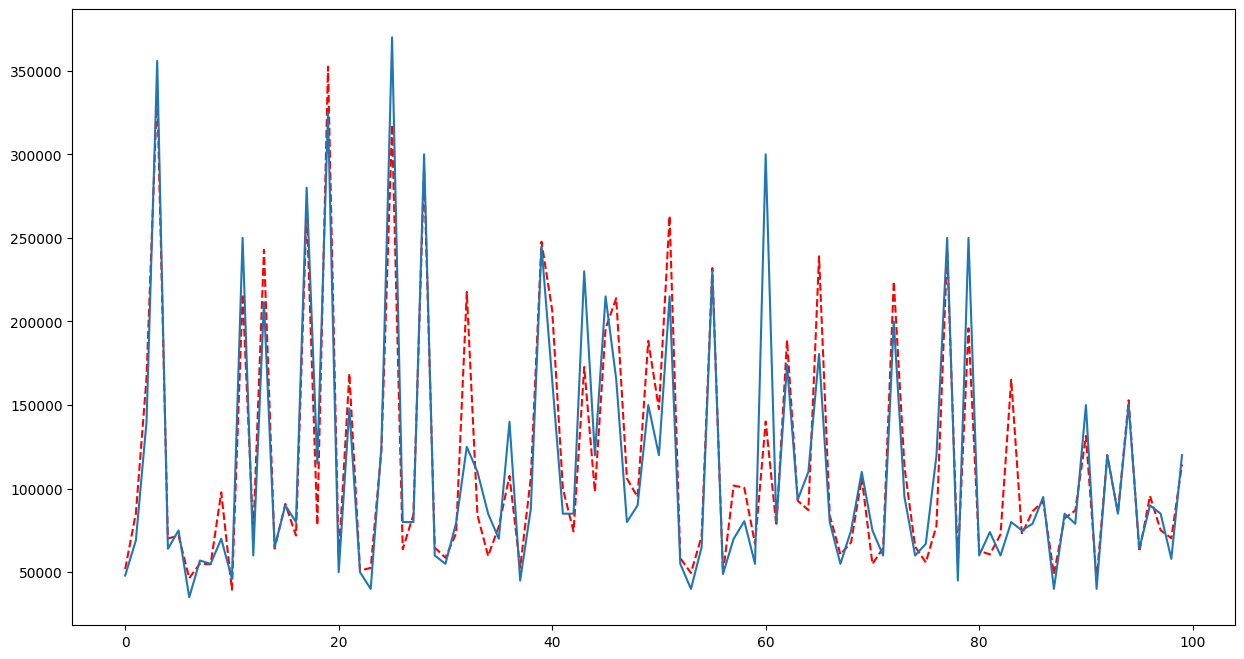

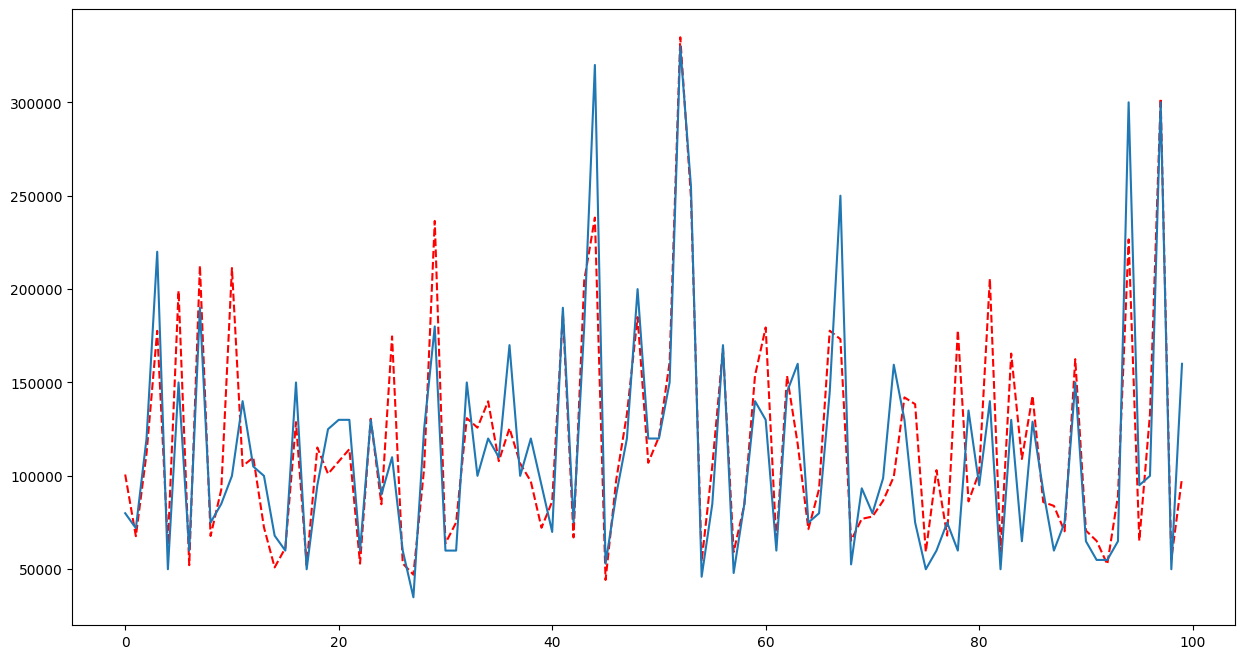

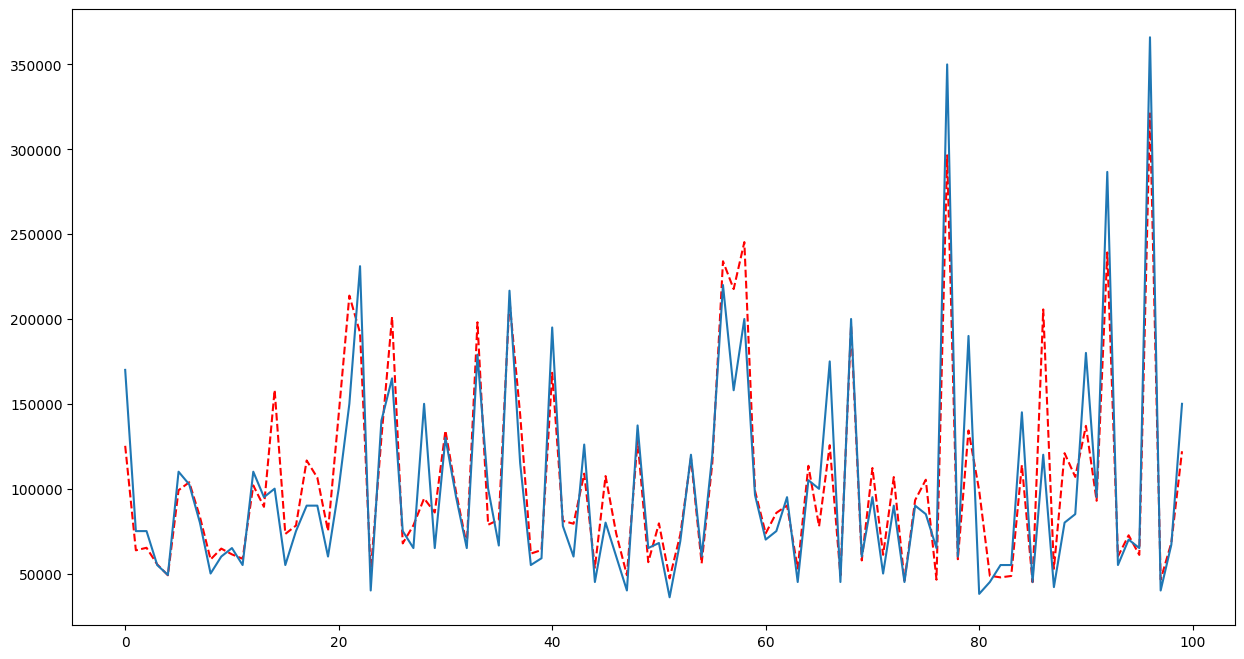

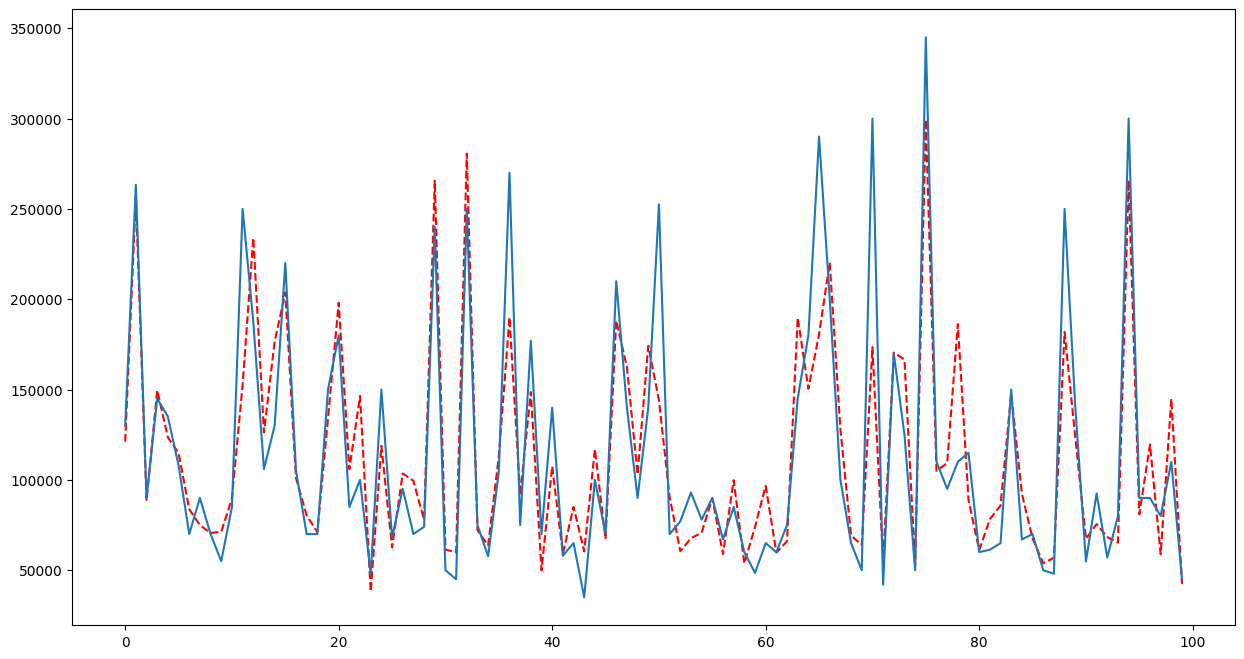

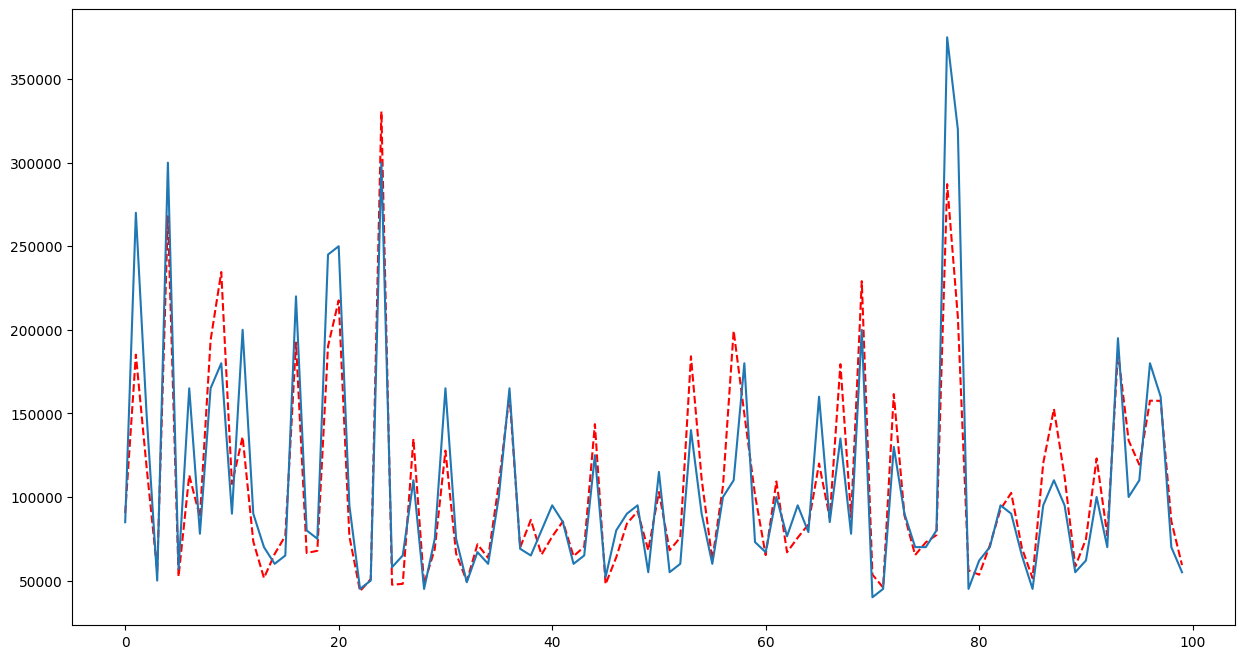

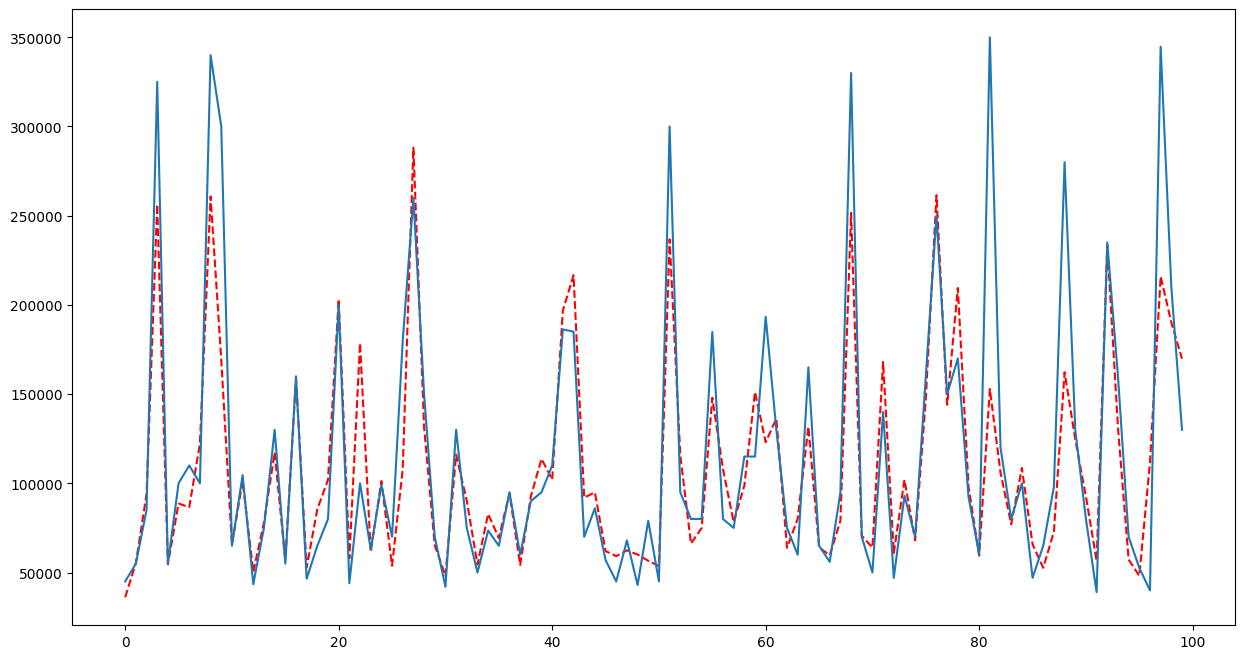

In [14]:
for num in np.arange(0, 1000, 100):
    plt.figure(figsize = (15, 8))
    plt.plot(range(100), XGB_best.predict(X_hold)[num:(num + 100)], color = 'red', linestyle = '--')
    plt.plot(range(100), y_hold[num:(num + 100)])
    plt.show()